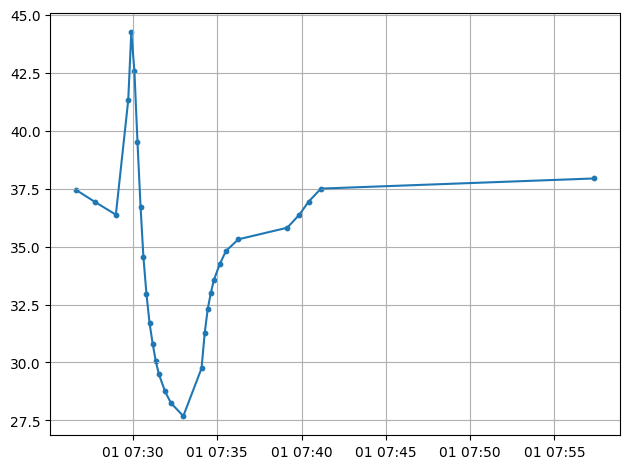

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("teplota_log.csv", header=None, names=["Time", "Value"])
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df = df.dropna().sort_values("Time").drop_duplicates("Time")

df_plot = df[df["Time"] >= df["Time"].max() - pd.Timedelta(hours=1)]

plt.plot(df_plot["Time"], df_plot["Value"])
plt.scatter(df_plot["Time"], df_plot["Value"], s=10)
plt.grid()
plt.tight_layout()
plt.show()


In [12]:
 
df_plot.tail(20)


,Time,Value
1106,2026-02-01 07:30:59,31.687
1107,2026-02-01 07:31:10,30.812
1108,2026-02-01 07:31:21,30.062
1109,2026-02-01 07:31:32,29.500
1110,2026-02-01 07:31:54,28.750
1111,2026-02-01 07:32:15,28.250
1112,2026-02-01 07:32:59,27.687
1113,2026-02-01 07:34:04,29.750
1114,2026-02-01 07:34:15,31.250
1115,2026-02-01 07:34:26,32.312


In [13]:
import pandas as pd

path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/Weather.csv"

# Přeskočíme prvních 5 řádků, kde nejsou data
df_netatmo = pd.read_csv(path, skiprows=5)

# Oprava názvů sloupců
df_netatmo.columns = ["timestamp", "time_str", "temperature", "humidity", "empty"]

# Odstranění prázdného sloupce
df_netatmo = df_netatmo.drop(columns=["empty"])

# Převod timestamp → datetime
df_netatmo["time_utc"] = pd.to_datetime(df_netatmo["timestamp"], unit="s")

# Převod textového času → datetime
df_netatmo["time_local"] = pd.to_datetime(df_netatmo["time_str"])

df_netatmo


,timestamp,time_str,temperature,humidity,time_utc,time_local
0,1767222900,2026/01/01 00:15:00,1.5,86,2025-12-31 23:15:00,2026-01-01 00:15:00
1,1767224700,2026/01/01 00:45:00,1.6,85,2025-12-31 23:45:00,2026-01-01 00:45:00
2,1767226500,2026/01/01 01:15:00,1.7,85,2026-01-01 00:15:00,2026-01-01 01:15:00
3,1767228300,2026/01/01 01:45:00,1.8,85,2026-01-01 00:45:00,2026-01-01 01:45:00
4,1767230100,2026/01/01 02:15:00,1.8,85,2026-01-01 01:15:00,2026-01-01 02:15:00
...,...,...,...,...,...,...
1476,1769879700,2026/01/31 18:15:00,-0.8,84,2026-01-31 17:15:00,2026-01-31 18:15:00
1477,1769881500,2026/01/31 18:45:00,-1.1,84,2026-01-31 17:45:00,2026-01-31 18:45:00
1478,1769883300,2026/01/31 19:15:00,-1.3,84,2026-01-31 18:15:00,2026-01-31 19:15:00
1479,1769883300,2026/01/31 22:55:00,-1.7,84,2026-01-31 18:15:00,2026-01-31 22:55:00


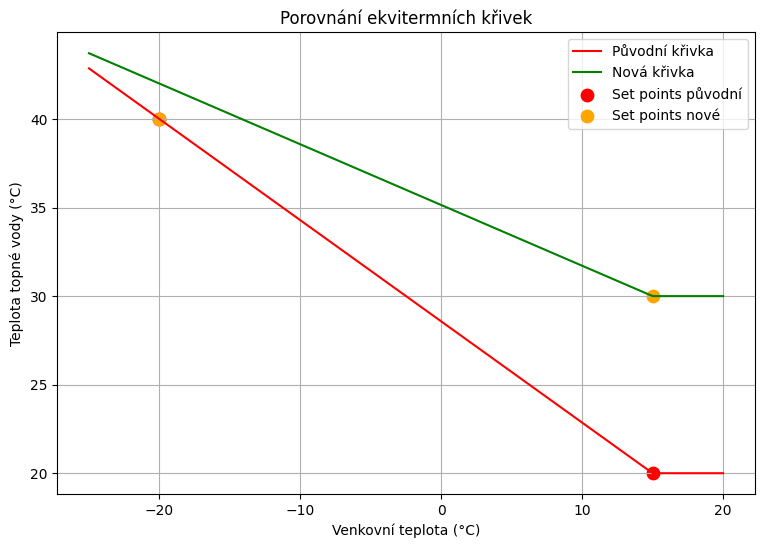

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Původní křivka
def hokejka(temp_in):
    if temp_in <= 15:
        return -0.571428 * temp_in + 28.5714
    else:
        return 20

# Nová křivka podle bodů A(-20/42) a B(15/30)
def hokejka2(temp_in):
    if temp_in <= 15:
        return -0.342857 * temp_in + 35.143
    else:
        return 30


# Data pro graf
temps_in = np.linspace(-25, 20, 200)
temps_out_1 = [hokejka(t) for t in temps_in]
temps_out_2 = [hokejka2(t) for t in temps_in]

# Vykreslení
plt.figure(figsize=(9, 6))
plt.plot(temps_in, temps_out_1, label="Původní křivka", color="red")
plt.plot(temps_in, temps_out_2, label="Nová křivka", color="green")

# Body původní křivky
plt.scatter([-20, 15], [40, 20], color="red", s=80, label="Set points původní")

# Body nové křivky
plt.scatter([-20, 15], [40, 30], color="orange", s=80, label="Set points nové")

plt.title("Porovnání ekvitermních křivek")
plt.xlabel("Venkovní teplota (°C)")
plt.ylabel("Teplota topné vody (°C)")
plt.grid(True)
plt.legend()

# Uložení grafu
plt.savefig("Equit_graf.png")

plt.show()




In [15]:
import pandas as pd

# Původní křivka
def hokejka(temp_in):
    if temp_in <= 15:
        return -0.571428 * temp_in + 28.5714
    else:
        return 20

# Nová křivka podle bodů A(-20/40) a B(15/30)
def hokejka2(temp_in):
    if temp_in <= 15:
        return -0.342857 * temp_in + 35.143
    else:
        return 30

# Sloupec Boiler_water
df_netatmo["Boiler_water"] = df_netatmo["temperature"].apply(hokejka)

# Nový sloupec Boiler_water_2
df_netatmo["Boiler_water_2"] = df_netatmo["temperature"].apply(hokejka2)

# Ukázka posledních 10 řádků
df_netatmo.tail(10)


,timestamp,time_str,temperature,humidity,time_utc,time_local,Boiler_water,Boiler_water_2
1471,1769870700,2026/01/31 15:45:00,1.3,81,2026-01-31 14:45:00,2026-01-31 15:45:00,27.828544,34.697286
1472,1769872500,2026/01/31 16:15:00,0.8,82,2026-01-31 15:15:00,2026-01-31 16:15:00,28.114258,34.868714
1473,1769874300,2026/01/31 16:45:00,0.4,83,2026-01-31 15:45:00,2026-01-31 16:45:00,28.342829,35.005857
1474,1769876100,2026/01/31 17:15:00,-0.1,83,2026-01-31 16:15:00,2026-01-31 17:15:00,28.628543,35.177286
1475,1769877900,2026/01/31 17:45:00,-0.5,83,2026-01-31 16:45:00,2026-01-31 17:45:00,28.857114,35.314428
1476,1769879700,2026/01/31 18:15:00,-0.8,84,2026-01-31 17:15:00,2026-01-31 18:15:00,29.028542,35.417286
1477,1769881500,2026/01/31 18:45:00,-1.1,84,2026-01-31 17:45:00,2026-01-31 18:45:00,29.199971,35.520143
1478,1769883300,2026/01/31 19:15:00,-1.3,84,2026-01-31 18:15:00,2026-01-31 19:15:00,29.314256,35.588714
1479,1769883300,2026/01/31 22:55:00,-1.7,84,2026-01-31 18:15:00,2026-01-31 22:55:00,29.542828,35.725857
1480,1769883300,2026/02/01 7:45:00,-3.8,84,2026-01-31 18:15:00,2026-02-01 07:45:00,30.742826,36.445857


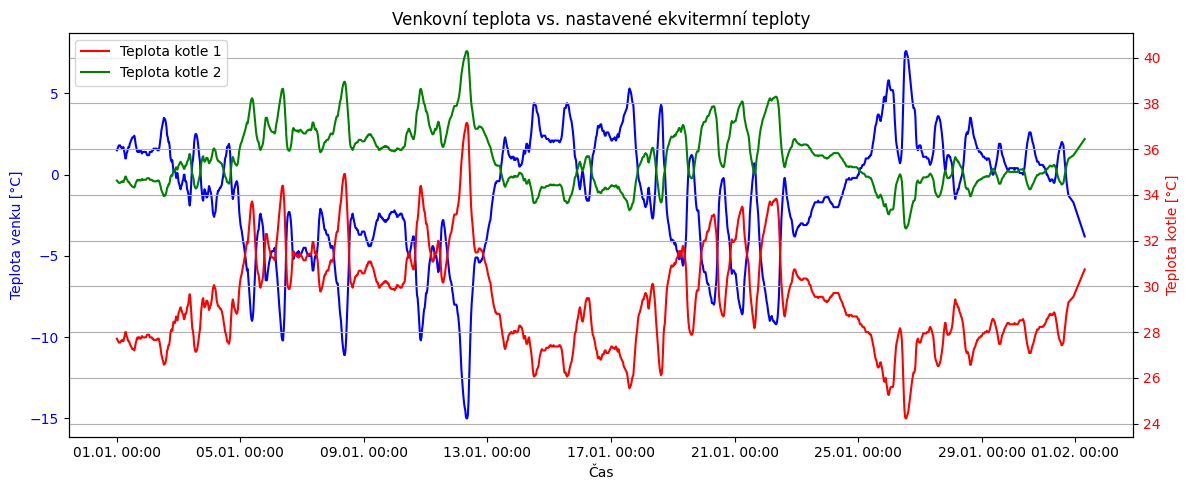

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))

# Hlavní osa
ax = plt.gca()

# Venkovní teplota
ax.plot(df_netatmo["time_local"], df_netatmo["temperature"], color="blue")
ax.set_ylabel("Teplota venku [°C]", color="blue")
ax.tick_params(axis="y", labelcolor="blue")

# Vedlejší osa (Boiler_water)
ax2 = ax.twinx()
ax2.plot(df_netatmo["time_local"], df_netatmo["Boiler_water"], color="red", label="Teplota kotle 1")
ax2.plot(df_netatmo["time_local"], df_netatmo["Boiler_water_2"], color="green", label="Teplota kotle 2")

ax2.set_ylabel("Teplota kotle [°C]", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Titulek a popisky
plt.title("Venkovní teplota vs. nastavené ekvitermní teploty")
ax.set_xlabel("Čas")

# Formátování osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
plt.xticks(rotation=45)

# Legenda pro vedlejší osu
ax2.legend(loc="upper left")

plt.grid(True)
plt.tight_layout()
plt.show()


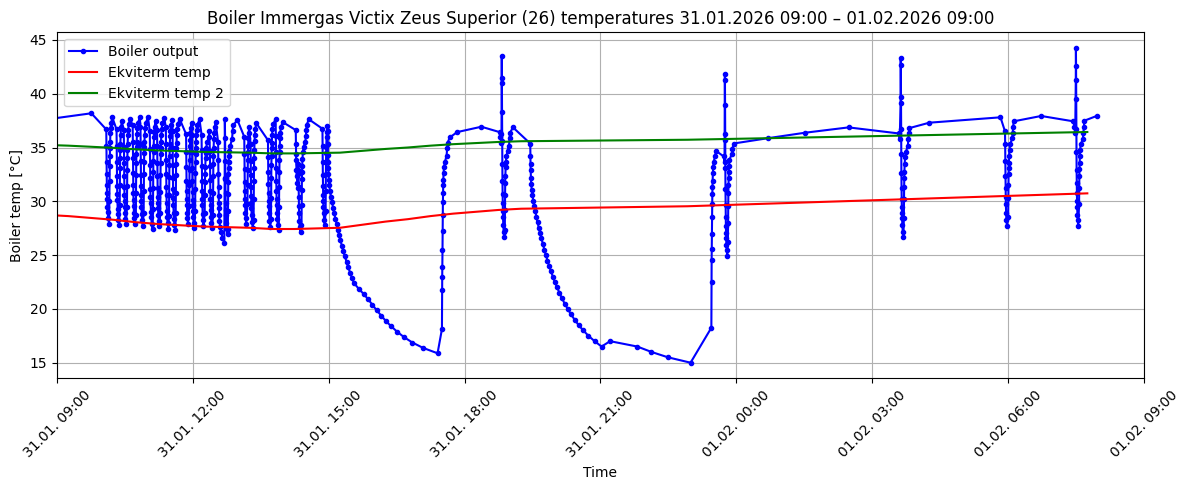

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# --- RUČNÍ NASTAVENÍ ČASOVÉHO OKNA ---
start_time = pd.Timestamp("2026-01-31 9:00:00")
end_time   = pd.Timestamp("2026-02-1 9:00:00")

plt.figure(figsize=(12,5))
ax = plt.gca()

# Kotel
ax.plot(df["Time"], df["Value"], marker=".", color="blue", label="Boiler output")

# Netatmo – původní křivka
ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water"], color="red", label="Ekviterm temp")

# Netatmo – nová křivka (Boiler_water_2)
ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water_2"], color="green", label="Ekviterm temp 2")

# --- APLIKACE ČASOVÉHO OKNA NA GRAF ---
ax.set_xlim(start_time, end_time)

# Formát osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
plt.xticks(rotation=45)

plt.title(f"Boiler Immergas Victix Zeus Superior (26) temperatures {start_time:%d.%m.%Y %H:%M} – {end_time:%d.%m.%Y %H:%M}")

ax.set_xlabel("Time")
ax.set_ylabel("Boiler temp [°C]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



/var/folders/px/7v29qw4j1fq7r7dx3wzzggyr0000gn/T/ipykernel_1390/3204442714.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], errors="coerce")


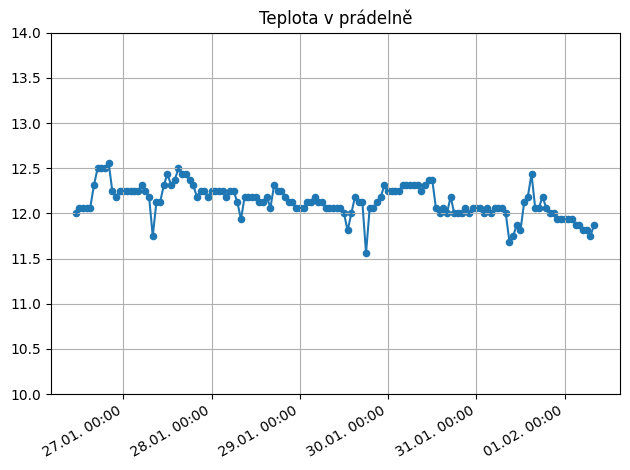

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_pradelna = pd.read_csv("teplota_pradelna.csv", header=None, names=["cas", "tepl"])
df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], errors="coerce")
df_pradelna["tepl"] = pd.to_numeric(df_pradelna["tepl"], errors="coerce")
df_pradelna = df_pradelna.dropna().sort_values("cas").drop_duplicates("cas")

fig, ax = plt.subplots()

ax.set_ylim(10, 14)
ax.set_title("Teplota v prádelně")

ax.plot(df_pradelna["cas"], df_pradelna["tepl"])
ax.scatter(df_pradelna["cas"], df_pradelna["tepl"], s=20)

ax.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()




In [19]:
df_pradelna

,cas,tepl
1,2026-01-26 11:15:44,12.000
2,2026-01-26 12:00:03,12.062
3,2026-01-26 13:00:03,12.062
4,2026-01-26 14:00:03,12.062
5,2026-01-26 15:00:03,12.062
...,...,...
138,2026-02-01 04:00:03,11.875
139,2026-02-01 05:00:03,11.812
140,2026-02-01 06:00:03,11.812
141,2026-02-01 07:00:03,11.750
